In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
from music21 import *
!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

# ACCESS THE KAGGLE.JSON FILE TO DOWNLOAD LAKH-MIDI-DATASET FROM KAGGLE

In [ ]:
!cp "/content/drive/MyDrive/SPEECH PROJECT/kaggle.json" "/content/"
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d imsparsh/lakh-midi-clean

 93% 211M/226M [00:01<00:00, 185MB/s]
100% 226M/226M [00:01<00:00, 156MB/s]


# UNZIP THE DATASET FOLDER -->

In [ ]:
!mkdir "/content/LAKH-MIDI-CLEAN-DATASET/"
!unzip "lakh-midi-clean.zip" -d "/content/LAKH-MIDI-CLEAN-DATASET/lakh_midi_clean"

In [ ]:
!mkdir "/content/midi_dataset/"

# MAKE A LIST OF ALL THE FOLDERS IN THE DATASET DIRECTORY -->

In [ ]:
import os

folders_list = []
for each in os.listdir("/content/LAKH-MIDI-CLEAN-DATASET/lakh_midi_clean/"):
  folders_list.append(os.path.join("/content/LAKH-MIDI-CLEAN-DATASET/lakh_midi_clean/", each))
print(folders_list)
print("Number of Folders in the dataset: ", len(folders_list))
#Each folder consists multiple .midi files.

# COPY ALL THE MIDI FILES FROM DIFFERENT SUB-FOLDERS INTO A SINGLE DIRECTORY FOR EASE OF ACCESS -->

In [ ]:
import os
import shutil

src = r'/content/LAKH-MIDI-CLEAN-DATASET/lakh_midi_clean'
dest = r'/content/midi_dataset/'

for path, subdirs, files in os.walk(src):
    for name in files:
        filename = os.path.join(path, name)
        shutil.copy2(filename, dest)

In [ ]:
len(os.listdir("/content/midi_dataset/"))

15989

# MIDI TO IMAGE (EXTRACT NOTES, DURATION AND CHORDS OF THE MIDI FILES) -->

In [ ]:
from music21 import converter, instrument, note, chord
import sys
import numpy as np
from imageio import imwrite

def extractNote(element):
    return int(element.pitch.ps)

def extractDuration(element):
    return element.duration.quarterLength

def get_notes(notes_to_parse):

    """ Get all the notes and chords from the midi files """
    durations = []
    notes = []
    start = []

    for element in notes_to_parse:
        if isinstance(element, note.Note):
            if element.isRest:
                continue

            start.append(element.offset)
            notes.append(extractNote(element))
            durations.append(extractDuration(element))

        elif isinstance(element, chord.Chord):
            if element.isRest:
                continue
            for chord_note in element:
                start.append(element.offset)
                durations.append(extractDuration(element))
                notes.append(extractNote(chord_note))

    return {"start":start, "pitch":notes, "dur":durations}


def midi2image(midi_path, max_repetitions = float("inf"), resolution = 0.25, lowerBoundNote = 21, upperBoundNote = 127, maxSongLength = 100):

    try:
        mid = converter.parse(midi_path)
        instruments = instrument.partitionByInstrument(mid)
        data = {}

        try:
            i=0
            for instrument_i in instruments.parts:
                notes_to_parse = instrument_i.recurse()

                notes_data = get_notes(notes_to_parse) # EXTRACTING ALL THE MULTIPLE SUB-NOTES AT A PARTICULAR PERIOD OF DURATION IF FOUND, ELSE, EXTRACTING THE NOTE FOUND.
                if len(notes_data["start"]) == 0:
                    continue

                if instrument_i.partName is None:
                    data["instrument_{}".format(i)] = notes_data
                    i+=1
                else:
                    data[instrument_i.partName] = notes_data # EXTRACTING INSTRUMENT'S NAME AS PER THE PITCH DETECTED.

        except:
            notes_to_parse = mid.flat.notes
            data["instrument_0"] = get_notes(notes_to_parse)

        for instrument_name, values in data.items():
            # https://en.wikipedia.org/wiki/Scientific_pitch_notation#Similar_systems

            pitches = values["pitch"]
            durs = values["dur"]
            starts = values["start"]

            index = 0
            while index < max_repetitions:
                matrix = np.zeros((upperBoundNote-lowerBoundNote,maxSongLength))


                for dur, start, pitch in zip(durs, starts, pitches):
                    dur = int(dur/resolution)
                    start = int(start/resolution)

                    if not start > index*(maxSongLength+1) or not dur+start < index*maxSongLength:
                        for j in range(start,start+dur):
                            if j - index*maxSongLength >= 0 and j - index*maxSongLength < maxSongLength:
                                matrix[pitch-lowerBoundNote,j - index*maxSongLength] = 255

                if matrix.any(): # If matrix contains no notes (only zeros) don't save it
                    imwrite(midi_path.split("/")[-1].replace(".mid",f"_{instrument_name}_{index}.png"),matrix.astype(np.uint8))
                    index += 1
                else:
                    break
    except:
        pass

In [ ]:
os.mkdir("/content/drive/MyDrive/SPEECH PROJECT/PNG_OUTPUTS/")
os.chdir("/content/drive/MydRIVE/SPEECH PROJECT/PNG_OUTPUTS/")

In [ ]:
if __name__ == "__main__":
    import tqdm.notebook as tq
    import os
    midi_path = "/content/midi_dataset/"
    file_count = 0
    from glob import glob
    files = glob(r"/content/midi_dataset/*.mid")
    from random import Random
    Random(9382).shuffle(files)
    for each in tq.tqdm(os.listdir(midi_path)):
      print(files[file_count])
      midi2image(files[file_count], 1)
      file_count += 1
      if file_count == 1000:
        break

In [ ]:
len(os.listdir("/content/drive/MyDrive/SPEECH PROJECT/PNG_FINAL"))

6376

#IMAGE TO MIDI

In [ ]:
from PIL import Image
import numpy as np
from music21 import instrument, note, chord, stream

lowerBoundNote = 21
def column2notes(column):
    notes = []
    for i in range(len(column)):
        if column[i] > 255/2:
            notes.append(i+lowerBoundNote)
    return notes

resolution = 0.25
def updateNotes(newNotes,prevNotes):
    res = {}
    for note in newNotes:
        if note in prevNotes:
            res[note] = prevNotes[note] + resolution
        else:
            res[note] = resolution
    return res

def image2midi(image_path):
    with Image.open(image_path) as image:
        im_arr = np.frombuffer(image.tobytes(), dtype=np.uint8)
        try:
            im_arr = im_arr.reshape((image.size[1], image.size[0]))
        except:
            im_arr = im_arr.reshape((image.size[1], image.size[0],3))
            im_arr = np.dot(im_arr, [0.33, 0.33, 0.33])

    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model

    prev_notes = updateNotes(im_arr.T[0,:],{})
    for column in im_arr.T[1:,:]:
        notes = column2notes(column)
        # pattern is a chord
        notes_in_chord = notes
        old_notes = prev_notes.keys()
        for old_note in old_notes:
            if not old_note in notes_in_chord:
                new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
                new_note.storedInstrument = instrument.Piano()
                if offset - prev_notes[old_note] >= 0:
                    new_note.offset = offset - prev_notes[old_note]
                    output_notes.append(new_note)
                elif offset == 0:
                    new_note.offset = offset
                    output_notes.append(new_note)
                else:
                    print(offset,prev_notes[old_note],old_note)

        prev_notes = updateNotes(notes_in_chord,prev_notes)

        # increase offset each iteration so that notes do not stack
        offset += resolution

    for old_note in prev_notes.keys():
        new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
        new_note.storedInstrument = instrument.Piano()
        new_note.offset = offset - prev_notes[old_note]

        output_notes.append(new_note)

    prev_notes = updateNotes(notes_in_chord,prev_notes)

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=image_path.split("/")[-1].replace(".png",".mid"))

# ACCESS IMAGES -->

In [ ]:
import os
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def inv_sigmoid(x):
    return np.log(x/(1-x))

%matplotlib inline

# path = '/content/output_images_copy/output_images/'
path = "/content/drive/MyDrive/SPEECH PROJECT/PNG_FINAL/"
os.getcwd()
img_list = os.listdir(path)
print(img_list)

def access_images(img_list,path):
    pixels = []
    imgs = []
    for i in range(len(os.listdir(path))):
        if 'png' in img_list[i]:
            img = Image.open(path+img_list[i],'r')
            img = img.convert('1')
            pix = np.array(img.getdata())
            pix = pix.astype('float32')
            pix /= 255.0
            # print(pix.shape)
            pixels.append(pix.reshape(106,100,1))
            imgs.append(img)
    return np.array(pixels),imgs

def show_image(pix_list):
    array = np.array(pix_list.reshape(106,106), dtype=np.uint8)
    new_image = Image.fromarray(array)
    new_image.show()

pixels,imgs = access_images(img_list,path)

In [ ]:
pixels.shape

(6447, 106, 100, 1)

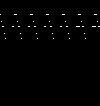

In [ ]:
imgs[1]

In [ ]:
np.unique(pixels)

array([0., 1.], dtype=float32)

# IMPORT LIBRARIES FOR GAN -->

In [ ]:
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten,BatchNormalization
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
from IPython.display import clear_output

# DEFINE DISCRIMINATOR -->

In [ ]:
def define_discriminator(in_shape = (106,100,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=0.00002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# DEFINE GENERATOR -->

In [ ]:
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 128 * 53 * 50
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((53, 50, 128))) # 106, 100
    model.add(Dense(1024))
    model.add(Conv2DTranspose(1024, (4,4), strides=(2,2), padding='same'))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1024))
    model.add(Conv2D(1, (7,7), padding='same',activation = 'sigmoid')) # 7x7
    return model

In [ ]:
generator = define_generator(100)
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 339200)            34259200  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 339200)            0         
                                                                 
 reshape (Reshape)           (None, 53, 50, 128)       0         
                                                                 
 dense_1 (Dense)             (None, 53, 50, 1024)      132096    
                                                                 
 conv2d_transpose (Conv2DTra  (None, 106, 100, 1024)   16778240  
 nspose)                                                         
                                                                 
 dense_2 (Dense)             (None, 106, 100, 1024)    1049600   
                                                        

# DEFINE GAN MODEL -->

In [ ]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model) # Noise generator (random) -> Generator, generator creates a fake image. This fake image goes inside the discriminator, disciriminator batayega ki fake hai ki nahi.
    model.add(d_model)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# FAKE SAMPLE AND REAL SAMPLE GENERATION FOR TRAINING -->

In [ ]:
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y

def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

# FUNCTION TO SUMMARIZE PERFORMANCE -->

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

In [ ]:
import keras

g_model = keras.models.load_model("/content/drive/MyDrive/SPEECH PROJECT/Generator_TRAINED_{i}.hdf5")
d_model = keras.models.load_model("/content/drive/MyDrive/SPEECH PROJECT/Discriminator_TRAINED_{i}.hdf5")
gan_model = keras.models.load_model("/content/drive/MyDrive/SPEECH PROJECT/GAN_FULL_TRAINED{i}.hdf5")

In [ ]:
import tqdm.notebook as tq
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
print(pixels.shape)

# Train the GAN model -->
dataset = np.array(pixels)
n_batch = 32
bat_per_epo = int(dataset.shape[0] / n_batch)
half_batch = int(n_batch / 2)
n_epochs = 100
g_loss_list = []
d_loss_list = []

for i in range(n_epochs):
    for j in range(bat_per_epo):
        X_real, y_real = generate_real_samples(dataset, half_batch)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
        d_loss, _ = d_model.train_on_batch(X, y)
        X_gan = generate_latent_points(latent_dim, n_batch)
        y_gan = ones((n_batch, 1)) # Batch size = n_batch
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
        g_loss_list.append(g_loss)
        d_loss_list.append(d_loss)
        print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
    if (i+1) % 10 == 0:
        summarize_performance(i, g_model, d_model, dataset, latent_dim)
        clear_output()
    g_model.save("/content/drive/MyDrive/SPEECH PROJECT/Generator_TRAINED_{i}.hdf5")
    d_model.save("/content/drive/MyDrive/SPEECH PROJECT/Discriminator_TRAINED_{i}.hdf5")
    gan_model.save("/content/drive/MyDrive/SPEECH PROJECT/GAN_FULL_TRAINED{i}.hdf5")

(6447, 106, 100, 1)
>1, 1/201, d=0.776, g=0.534
>1, 2/201, d=0.862, g=0.555
>1, 3/201, d=0.911, g=0.499
>1, 4/201, d=0.856, g=0.558
>1, 5/201, d=0.891, g=0.539
>1, 6/201, d=0.861, g=0.581
>1, 7/201, d=0.874, g=0.565
>1, 8/201, d=0.909, g=0.566
>1, 9/201, d=0.957, g=0.540
>1, 10/201, d=0.991, g=0.518
>1, 11/201, d=0.870, g=0.568
>1, 12/201, d=0.891, g=0.525
>1, 13/201, d=0.832, g=0.536
>1, 14/201, d=1.015, g=0.494
>1, 15/201, d=0.760, g=0.527
>1, 16/201, d=0.854, g=0.502
>1, 17/201, d=0.855, g=0.528
>1, 18/201, d=0.779, g=0.528
>1, 19/201, d=0.910, g=0.505
>1, 20/201, d=0.857, g=0.509
>1, 21/201, d=0.865, g=0.528
>1, 22/201, d=0.846, g=0.492
>1, 23/201, d=0.878, g=0.527
>1, 24/201, d=0.850, g=0.547
>1, 25/201, d=0.910, g=0.497
>1, 26/201, d=0.927, g=0.496
>1, 27/201, d=0.880, g=0.507
>1, 28/201, d=0.862, g=0.530
>1, 29/201, d=0.851, g=0.501
>1, 30/201, d=0.892, g=0.491
>1, 31/201, d=0.896, g=0.491
>1, 32/201, d=0.956, g=0.442
>1, 33/201, d=0.841, g=0.489
>1, 34/201, d=0.819, g=0.482
>1,

In [ ]:
gan_model = keras.models.load_model("/content/drive/MyDrive/SPEECH PROJECT/GAN_TRAINED_{i}.hdf5")

In [ ]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

model = g_model
latent_points = generate_latent_points(latent_dim,1)
X = g_model.predict(latent_points)
array = np.array(X.reshape(106,100),dtype = np.uint8)
array*= 255
new_image = Image.fromarray(array,'L')
new_image = new_image.save('composition.png')

In [ ]:
image2midi('composition.png')

In [ ]:
!fluidsynth -ni font.sf2 composition.mid -F output.wav -r 44100
from IPython.display import Audio
Audio('output.wav')